In [7]:
import sys
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm
import numpy as np
from typing import Union
import scipy
import matplotlib.pyplot as plt
from vesuvius_image import PapyrusImage
from vesuvius_image.utils import Timer
from vesuvius_image.volume import PapyrusVolume

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [10]:
INPUT_FOLDER = "../data"
WORKING_FOLDER = "../data/working"

# Load in the zarr files

In [4]:
# Constants
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27  # First slice in the z direction to use
Z_DIM = 10  # Number of slices in the z direction
Z_SLICE = slice(Z_START, Z_START + Z_DIM, None)

SUBFOLDERS = ["train_1", "train_2", "train_3"]

In [8]:
def load_data_slice(query_index, max_mem=1e9, count_only=False):
    """Loads a subset of the training data into GPU memory.  Slicing is done so as to
    produce roughly square regions of each dataset so that the slices do not exceed
    the required maximum memory size.

    Note that the mask data is only loaded into CPU, not onto GPU.
    """
    # one float stored for the labels and one for each level of Z used
    bytes_per_pixel = (Z_DIM + 1) * np.dtype("float32").itemsize

    slice_index = 0
    for subfolder in SUBFOLDERS:
        if count_only:
            print(slice_index)
        labelzarr = PapyrusImage(f"{WORKING_FOLDER}/{subfolder}/inklabels.imagezarr")
        fragzarr = PapyrusVolume(f"{WORKING_FOLDER}/{subfolder}/frag.volzarr")
        maskzarr = PapyrusImage(f"{WORKING_FOLDER}/{subfolder}/mask.imagezarr")

        # Keep cutting the largest dimensions in half until we're small enough to fit
        # in our memory limits.
        xsize, ysize = labelzarr.shape
        xcount, ycount = 1, 1
        while (xsize + BUFFER) * (ysize + BUFFER) * bytes_per_pixel > max_mem:
            if xsize > ysize:
                xsize = xsize // 2
                xcount += 1
            else:
                ysize = ysize // 2
                ycount += 1
        for x in range(xcount):
            for y in range(ycount):
                if (slice_index == query_index) and not count_only:
                    xslice = slice(max(0, xsize * x - BUFFER),
                                   min(labelzarr.shape[0], xsize * (x + 1) + BUFFER),
                                   None)
                    yslice = slice(max(0, ysize * y - BUFFER),
                                   min(labelzarr.shape[1], ysize * (y + 1) + BUFFER),
                                   None)
                    labels = torch.from_numpy(
                        labelzarr[xslice,yslice,0].astype(np.float32)
                    ).to(DEVICE)
                    surface_volume = torch.from_numpy(
                        fragzarr[xslice,yslice,Z_SLICE,0].astype(np.float32) / np.iinfo(np.uint16).max
                    ).to(DEVICE)
                    mask = maskzarr[xslice,yslice,0]
                    return labels, surface_volume, mask
                slice_index += 1

    if count_only:
        return slice_index

    raise ValueError(f"Query index {query_index} too large; only {slice_index} slices of data.")

In [11]:
# Here we're running it with "count_only" so that we can see how many slices of data there are in our zarrs.
total_slices = load_data_slice(0, max_mem=1e9, count_only=True)
print(total_slices)

0
Loading from existing zarr: 0.0360 seconds
Loading from existing zarr: 0.0010 seconds
Loading from existing zarr: 0.0010 seconds
4
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0010 seconds
Loading from existing zarr: 0.0000 seconds
10
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0010 seconds
Loading from existing zarr: 0.0000 seconds
12


Great.  So there's 12 total slices, slices 0-3 are from fragment 1, slices 4-9 are from fragment 2, and slices 10-11 are from fragment 3.
We'll select one slice from each fragment to be validation data and the remaining slices will provide training data.

In [12]:
validation_slices = [2, 6, 11]
training_slices = [i for i in range(total_slices) if i not in validation_slices]
print(training_slices)

[0, 1, 3, 4, 5, 7, 8, 9, 10]


# PyTorch DataSet

Now we will generate a custom PyTorch dataset:  if provided with a given slice index, it will load
the data from that slice into GPU memory.
Then every pixel (within the mask) inside that slice is available to access a small region around that pixel.

In [13]:
class SlicedDataset(data.Dataset):
    def __init__(self, query_slice):
        self.query_slice = query_slice
        labels, surface_volume, mask = load_data_slice(query_slice)
        self.labels = labels
        self.surface_volume = surface_volume
        self.mask = mask

        self.xvals, self.yvals = np.where(self.mask)
        xmask = ((self.xvals - BUFFER) > 0) & ((self.xvals + BUFFER) < self.labels.shape[0])
        ymask = ((self.yvals - BUFFER) > 0) & ((self.yvals + BUFFER) < self.labels.shape[1])
        self.xvals = self.xvals[xmask & ymask]
        self.yvals = self.yvals[xmask & ymask]

    def __len__(self):
        return len(self.xvals)

    def __getitem__(self, index):
        x = self.xvals[index]
        y = self.yvals[index]
        subvolume = self.surface_volume[x-BUFFER:x+BUFFER+1, y-BUFFER:y+BUFFER+1, :].view(1, BUFFER*2+1, BUFFER*2+1, Z_DIM)
        inklabel = self.labels[x, y].view(1)
        return x, y, subvolume, inklabel

# Demo NN
And here's a dead simple neural network model (the same one used for the demo from the organizers).
But now I'll show how to train and validate this model with the entire data from all three fragments.

In [14]:
model = nn.Sequential(
    nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.MaxPool3d(kernel_size=2, stride=2),
    nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.MaxPool3d(kernel_size=2, stride=2),
    nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.MaxPool3d(kernel_size=2, stride=2),
    #Flattens dimensions 1+ into a single dimension, so it is a dim=2 matrix afterwards
    nn.Flatten(start_dim=1),
    nn.LazyLinear(out_features=128),
    nn.ReLU(),
    nn.LazyLinear(out_features=1),
    # Convert from (-inf, inf) to (0, 1) probability with a sigmoid
    nn.Sigmoid()
).to(DEVICE)

C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [15]:
training_losses = []
validation_losses = []

In [16]:
print("Training...")
TRAINING_STEPS_PER_SLICE = 64
LEARNING_RATE = 0.03
BATCH_SIZE = 48 # 16 uses 1.9 GB
EPOCH_COUNT = 5

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

for i in range(EPOCH_COUNT):
    print(f"Processing epoch {i+1}")

    epoch_training_loss = [0.0, 0]
    for tr_item in training_slices:
        train_dataset = SlicedDataset(tr_item)
        if len(train_dataset) == 0:
            # Just in case one of the slices is entirely empty (because of the mask)
            continue
        print(f"Training on data slice {tr_item}")
        training_steps = min(len(train_dataset), TRAINING_STEPS_PER_SLICE)
        train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=LEARNING_RATE, total_steps=training_steps
        )
        model.train()
        for i, (_, _, subvolumes, inklabels) in enumerate(train_loader):
            if i >= training_steps:
                break
            optimizer.zero_grad()
            outputs = model(subvolumes.to(DEVICE))
            loss = criterion(outputs, inklabels.to(DEVICE))
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_training_loss[0] += loss.item()
            epoch_training_loss[1] += 1
        del train_dataset, train_loader, scheduler, _, loss, subvolumes, inklabels
        torch.cuda.empty_cache()
    training_losses.append(epoch_training_loss[0] / epoch_training_loss[1])

    val_training_loss = [0.0, 0]
    for val_item in validation_slices:
        val_dataset = SlicedDataset(val_item)
        if len(val_dataset) == 0:
            continue
        print(f"Validating on data slice {val_item}")
        val_steps = min(len(val_dataset), TRAINING_STEPS_PER_SLICE)
        val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
        model.eval()
        with torch.no_grad():
            for i, (_, _, subvolumes, inklabels) in enumerate(val_loader):
                if i > val_steps:
                    break
                outputs = model(subvolumes.to(DEVICE))
                loss = criterion(outputs, inklabels.to(DEVICE))
                val_training_loss[0] += loss.item()
                val_training_loss[1] += 1
        del val_dataset, val_loader, _, loss, subvolumes, inklabels
        torch.cuda.empty_cache()
    validation_losses.append(val_training_loss[0] / val_training_loss[1])

del optimizer
torch.cuda.empty_cache()

Training...
Processing epoch 1
Loading from existing zarr: 0.0010 seconds
Loading from existing zarr: 0.0010 seconds
Loading from existing zarr: 0.0000 seconds
Training on data slice 0
Loading from existing zarr: 0.0010 seconds
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0000 seconds
Training on data slice 1
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0000 seconds
Training on data slice 3
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0010 seconds
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0010 seconds
Training on data slice 4
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0010 seconds
Loading from existing zarr: 0.0000 seconds
Loading from existing zarr: 0.0000 seconds
Loading f

# Plots

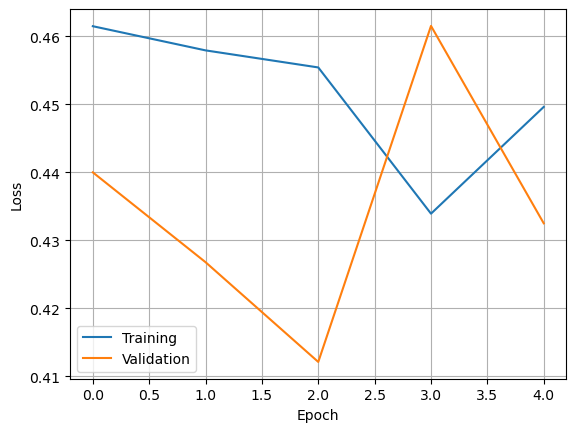

In [17]:
plt.figure()
plt.grid()

plt.plot(training_losses, label="Training")
plt.plot(validation_losses, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

So you can see that the model and training performance is pretty bad, but the actual data loading works fine: we just work with each bit of memory separately for either training, validation, or inference.

# From Adaptive Threshold notebook

In [19]:
labelzarr = PapyrusImage(f"{WORKING_FOLDER}/train_1/inklabels.imagezarr")
label = torch.from_numpy(labelzarr[:,:,0].astype(np.float32)).to(DEVICE)
fragzarr = PapyrusVolume(f"{WORKING_FOLDER}/train_1/frag.volzarr")

# N.B. the raw values are uint16, we need to cast to float and rescale to (0,1)
image_stack = torch.from_numpy(
    fragzarr[:,:,Z_START:Z_START+Z_DIM,0].astype(np.float32) / np.iinfo(np.uint16).max
).to(DEVICE)
maskzarr = PapyrusImage(f"{WORKING_FOLDER}/train_1/mask.imagezarr")
mask = maskzarr[:,:,0]

Loading from existing zarr: 0.0015 seconds
Loading from existing zarr: 0.0010 seconds
Loading from existing zarr: 0.0010 seconds


In [32]:
type(image_stack)

torch.Tensor

In [37]:
fragzarr[:, :, 2]

numpy.ndarray

## Create Pixel List

In [42]:
print("Generating pixel lists...")
pixels_list = set()
for pixel in zip(*np.where(mask)):
    if pixel[1] < BUFFER or pixel[1] >= mask.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= mask.shape[0]-BUFFER:
        continue # Too close to the edge of the image
    pixels_list.add(pixel)
pixels_list = list(pixels_list)

Generating pixel lists...


In [43]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1, :].view(1, BUFFER*2+1, BUFFER*2+1, Z_DIM)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel

In [44]:
print("Training on fragment 1...")
TRAINING_STEPS = 30000
LEARNING_RATE = 0.03
BATCH_SIZE = 32

train_dataset = SubvolumeDataset(image_stack, label, pixels_list)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
model.train()
running_loss = 0.0

for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS):
    if i >= TRAINING_STEPS:
        break
    optimizer.zero_grad()
    outputs = model(subvolumes.to(DEVICE))
    loss = criterion(outputs, inklabels.to(DEVICE))
    loss.backward()
    optimizer.step()
    scheduler.step()
    running_loss += loss.item()
    if i % 3000 == 3000-1:
        print("Loss:", running_loss / 3000)  # Would convert to a wandb log statement?
        running_loss = 0.0

  0%|          | 0/30000 [00:00<?, ?it/s]

Training on fragment 1...


 10%|█         | 3005/30000 [01:17<11:04, 40.61it/s]

Loss: 0.4284558987468481


 20%|██        | 6008/30000 [02:31<09:43, 41.10it/s]

Loss: 0.4137789645493031


 30%|███       | 9007/30000 [03:43<08:27, 41.39it/s]

Loss: 0.4096188316444556


 40%|████      | 12007/30000 [04:56<07:15, 41.33it/s]

Loss: 0.3924149348537127


 50%|█████     | 15006/30000 [06:08<05:56, 42.06it/s]

Loss: 0.3863574085036914


 60%|██████    | 18006/30000 [07:20<04:48, 41.57it/s]

Loss: 0.37590469398722054


 70%|███████   | 21005/30000 [08:33<03:31, 42.45it/s]

Loss: 0.3605801526059707


 80%|████████  | 24004/30000 [09:46<02:26, 40.87it/s]

Loss: 0.33446644663314024


 90%|█████████ | 27008/30000 [10:59<01:12, 41.26it/s]

Loss: 0.30603018746028343


100%|██████████| 30000/30000 [12:11<00:00, 41.00it/s]

Loss: 0.2772427087426186


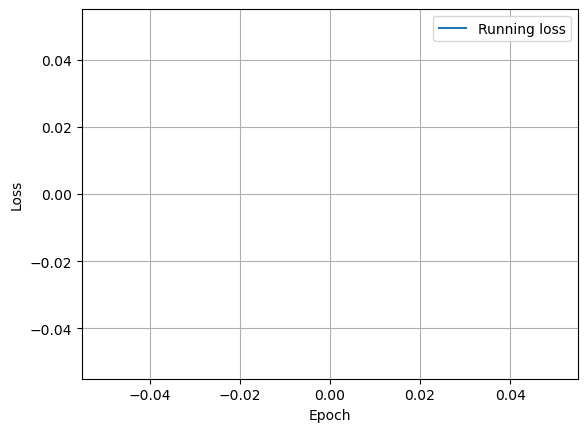

In [46]:
plt.figure()
plt.grid()

plt.plot(running_loss, label="Running loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

This is obviously non-kosher, but we're just going to evaluate the trained model on the training set itself to get some ML output data to play with.

In [50]:
import time
start = time.time()
eval_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
output = torch.zeros_like(label).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        for j, value in enumerate(model(subvolumes.to(DEVICE))):
            output[pixels_list[i*BATCH_SIZE+j]] = value
end = time.time()
print(f"Total time was: {end - start} seconds")

100%|██████████| 910529/910529 [1:36:54<00:00, 156.61it/s]


Total time was: 5814.858336448669 seconds


AttributeError: 'str' object has no attribute 'get_position'

<Figure size 640x480 with 2 Axes>

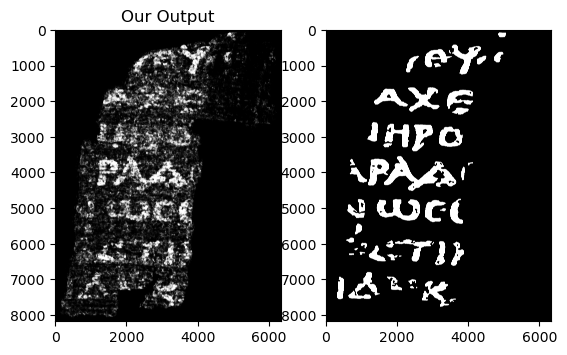

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')

ax1.set_title("Our Output")
ax2.imshow(label.cpu(), cmap='gray')
ax2.set_title = "Ground Truth"

plt.show()

And since it took a couple hours to do the inference here, i'm going to save the output array so i can use it again later without spending all this time

In [55]:
np.save("../data/working/frag1_results.array", output.cpu().numpy())

In [ ]:
plt.imshow(output.cpu() > 0.55, cmap='gray')

# Compare different thresholds

In [56]:
def dice_coef(preds, targets, beta=0.5, smooth=1e-5):
    preds = preds.view(-1).float()
    targets = targets.view(-1).float()

    y_true_count = targets.sum()
    ctp = preds[targets == 1].sum()
    cfp = preds[targets == 0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)
    return dice

In [57]:
thresholds = np.linspace(0.2, 0.9, 25)
scores = np.zeros_like(thresholds)
for i, t in enumerate(tqdm(thresholds)):
    scores[i] = dice_coef(output > t, label)

100%|██████████| 25/25 [00:00<00:00, 31.78it/s]


0.55 0.7137308716773987


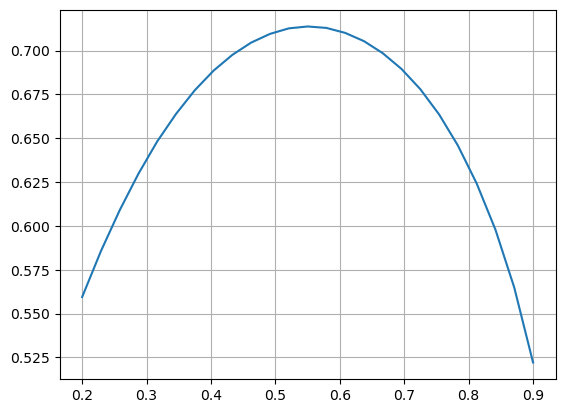

In [58]:
plt.figure()
plt.grid()
plt.plot(thresholds, scores)
idx = np.argmax(scores)
print(thresholds[idx], scores[idx])

Cool. So the maximum score is about 0.713 at a threshold of 0.55. Let's take a quick look at what the image looks like.

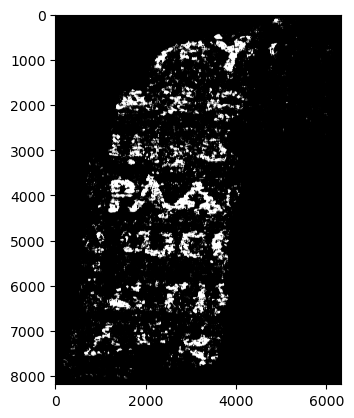

In [59]:
plt.imshow(output.cpu() > 0.55, cmap='gray')

Now, what I want to do is see how large the computed inked areas are for each threshold. sklearn has some tools that will make this fairly straightforward.

In [60]:
from skimage import measure, data
import pandas as pd

output_labels = measure.label(output.cpu() > 0.55, connectivity=2)
print(output_labels.max())

24237


OK. So we found 26,645 different contiguous regions of ink at this threshold. Let's see if we can break down some of the properties of these regions

In [61]:
properties = [
    "label",
    "area",
    "area_bbox",
    "area_convex",
    "axis_major_length",
]
output_table = pd.DataFrame(
    measure.regionprops_table(
        output_labels, properties=properties
    )
)
output_table.head()

,label,area,area_bbox,area_convex,axis_major_length
0,1,17.0,26.0,21.0,13.570720
1,2,7631.0,13965.0,10271.0,123.593578
2,3,1.0,1.0,1.0,0.000000
3,4,59.0,147.0,95.0,20.217674
4,5,5.0,5.0,5.0,5.656854


I've pulled out some properties that sklearn can compute that I thought might be relevant: label is just a range of integer labels for each distinct region, area is the number of pixels it covers, area_bbox is the area of the bounding box covering that region, area_convex is the area of the convex hull covering that region, and axis_major_length is the longer length of an ellipse fitted to that region.

Let's look at the distribution of these properties across all my regions.

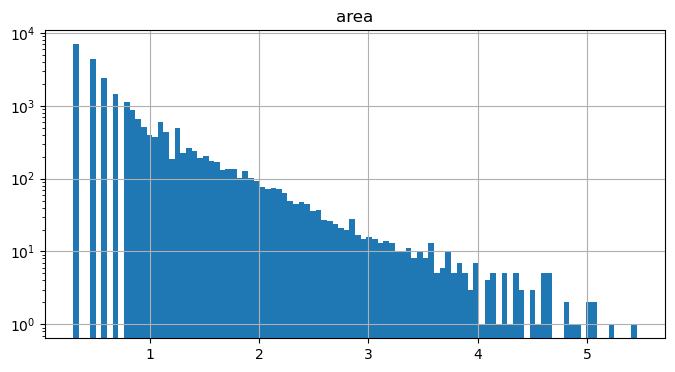

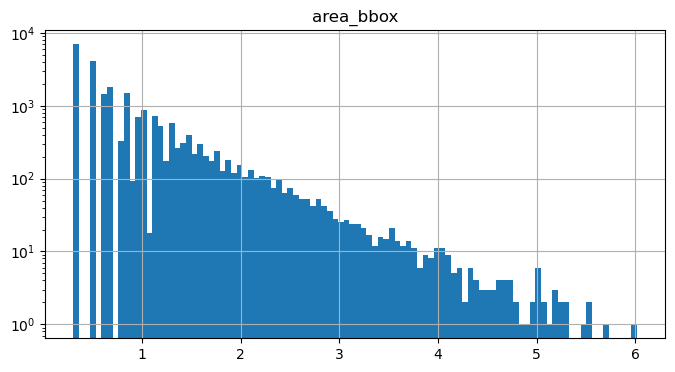

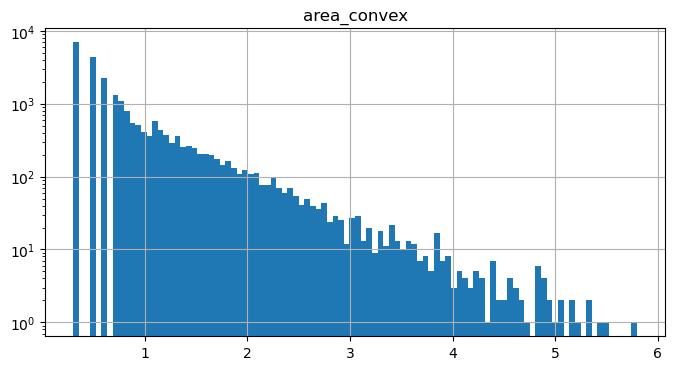

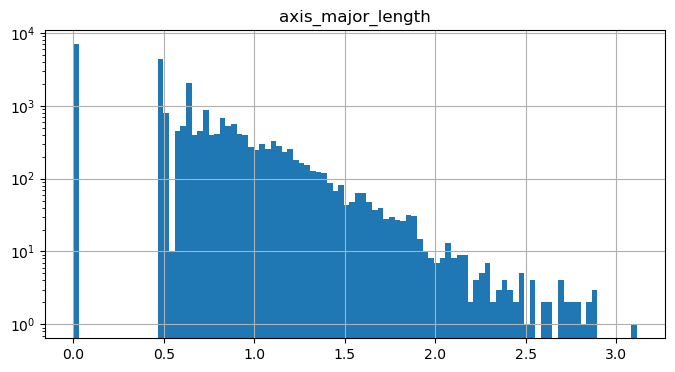

In [62]:
for prop in properties:
    if prop == "label":
        continue
    plt.figure(figsize=(8, 4))
    plt.grid()
    plt.title(prop)
    plt.hist(np.log1p(output_table[prop].values) / np.log(10), bins=100);
    plt.yscale('log')

In [63]:
print('end')

end
